In [1]:
# Phase 3: Explainable AI (SHAP)
# Goal:
# - Explain Confirm_Benign decisions
# - Explain Confirm_Malignant decisions
# - Analyze Uncertain cases
#
# Dataset: UCI WDBC
# Model: Logistic Regression
# Three-Way thresholds: alpha=0.91, beta=0.19

In [4]:
import pandas as pd
import numpy as np

from src.load_wdbc import load_uci_wdbc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# Load UCI raw dataset
X, y, ids = load_uci_wdbc("../data/raw/wdbc.data")

# Same split (important for consistent results)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train Logistic Regression with scaling
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

clf = LogisticRegression(max_iter=5000)
clf.fit(X_train_s, y_train)

# Probabilities for benign (class 1)
p_test = clf.predict_proba(X_test_s)[:, 1]
print("Test size:", len(X_test))

Test size: 114


In [5]:
df_labels = pd.read_csv("../results/test_with_three_way_labels.csv")

# uncertain indices (these align with X_test row order because you saved X_test into the CSV originally)
unc_idx = df_labels.index[df_labels["decision"] == "Uncertain"].tolist()
print("Uncertain cases:", len(unc_idx))

# pick 5 most ambiguous uncertain cases (closest to 0.5)
df_unc = df_labels.loc[unc_idx].copy()
df_unc["ambiguity"] = (df_unc["p_class1"] - 0.5).abs()
top_uncertain = df_unc.sort_values("ambiguity").head(5)

top_uncertain[["p_class1", "y_true", "decision", "ambiguity"]]

Uncertain cases: 16


,p_class1,y_true,decision,ambiguity
3,0.533509,1,Uncertain,0.033509
66,0.537046,1,Uncertain,0.037046
51,0.546639,1,Uncertain,0.046639
38,0.621263,1,Uncertain,0.121263
16,0.365862,1,Uncertain,0.134138


In [6]:
import shap

# SHAP explainer for linear model
explainer = shap.LinearExplainer(clf, X_train_s, feature_names=X_train.columns)
shap_values = explainer(X_test_s)  # SHAP values for each test sample

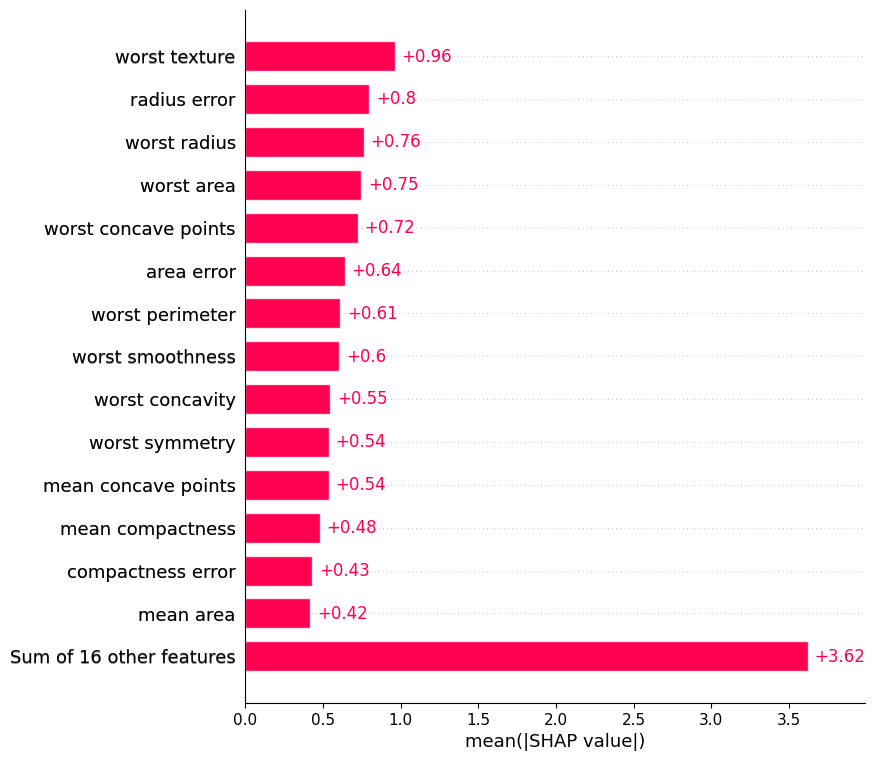

Saved: reports/figures/shap_global_bar.png


In [7]:
import matplotlib.pyplot as plt

shap.plots.bar(shap_values, max_display=15, show=False)
plt.savefig("../reports/figures/shap_global_bar.png", dpi=300, bbox_inches="tight")
plt.show()
print("Saved: reports/figures/shap_global_bar.png")

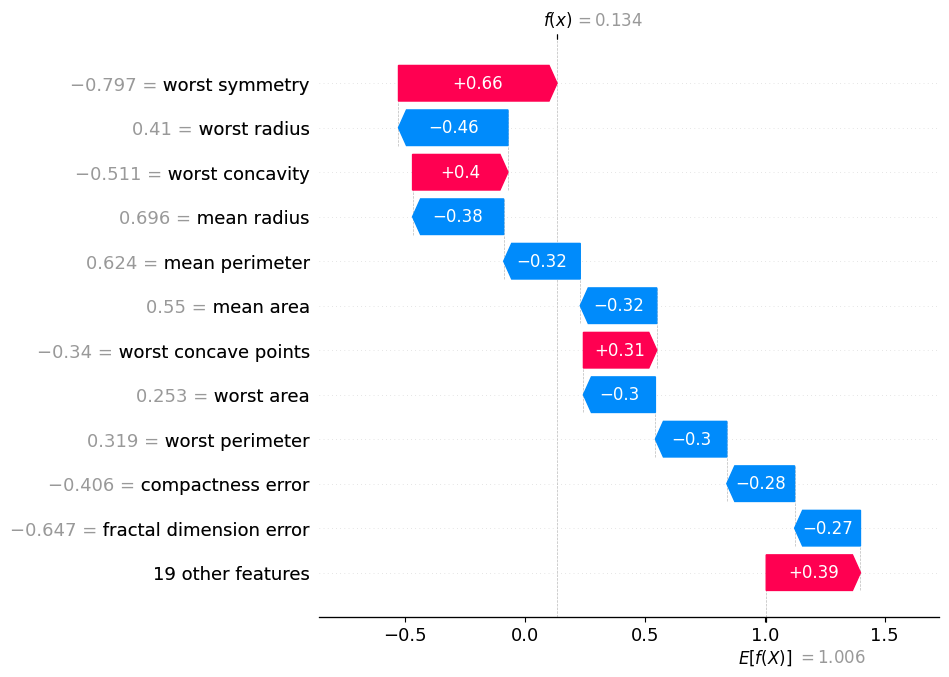

Saved: reports/figures/shap_uncertain_case_3.png


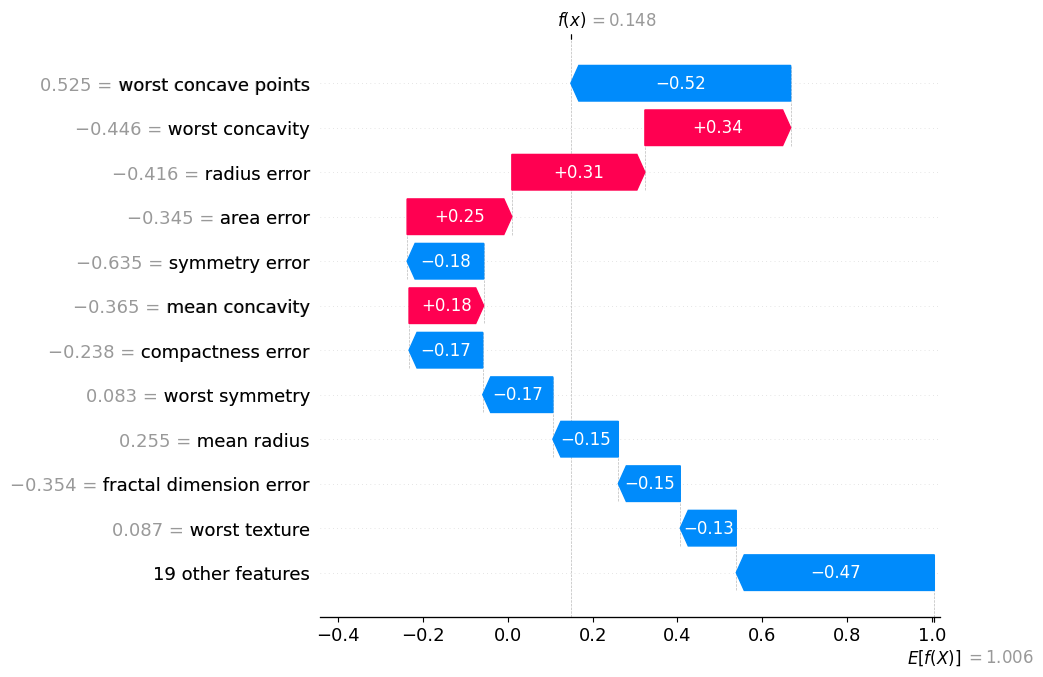

Saved: reports/figures/shap_uncertain_case_66.png


In [8]:
for i in top_uncertain.index[:2]:
    shap.plots.waterfall(shap_values[i], max_display=12, show=False)
    plt.savefig(f"../reports/figures/shap_uncertain_case_{i}.png", dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Saved: reports/figures/shap_uncertain_case_{i}.png")

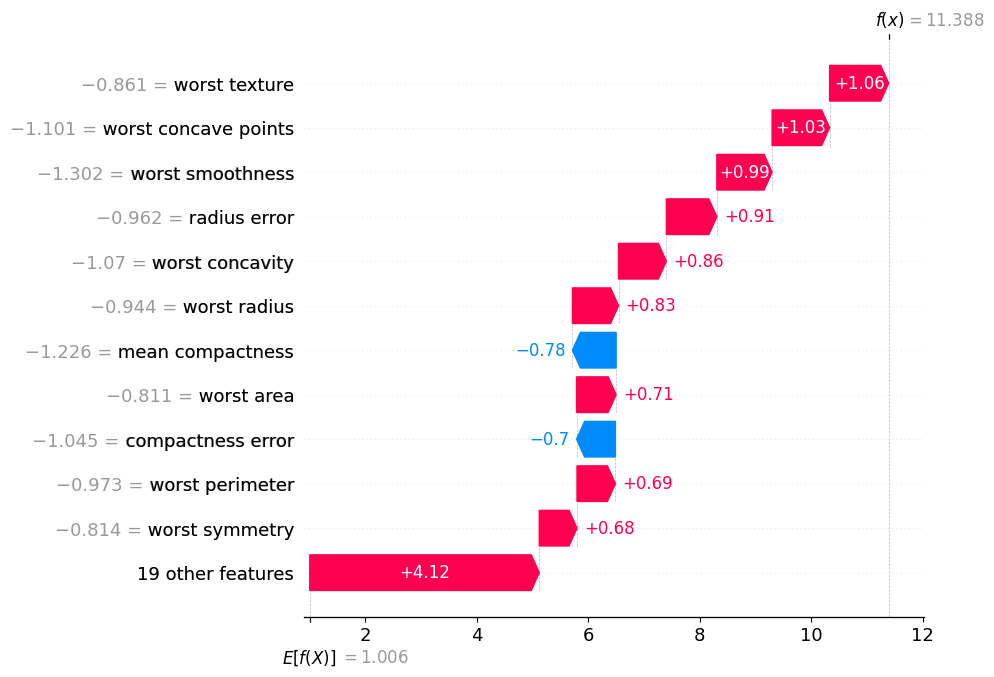

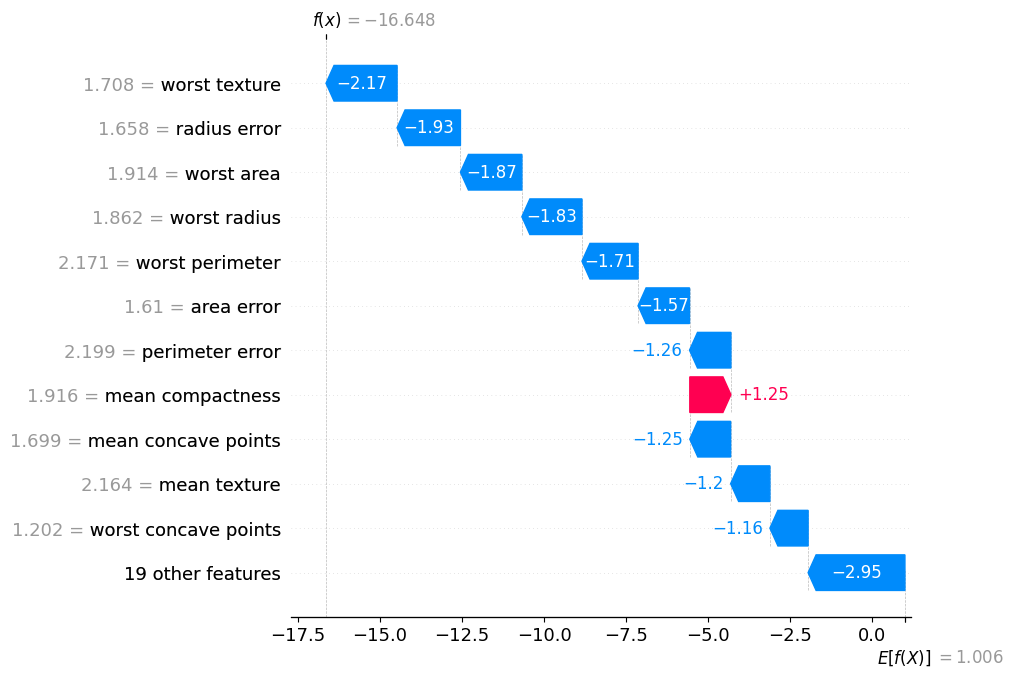

Saved confirm examples.


In [9]:
benign_idx = df_labels.index[df_labels["decision"] == "Confirm_Benign"][0]
malig_idx  = df_labels.index[df_labels["decision"] == "Confirm_Malignant"][0]

shap.plots.waterfall(shap_values[benign_idx], max_display=12, show=False)
plt.savefig("../reports/figures/shap_confirm_benign_example.png", dpi=300, bbox_inches="tight")
plt.show()

shap.plots.waterfall(shap_values[malig_idx], max_display=12, show=False)
plt.savefig("../reports/figures/shap_confirm_malignant_example.png", dpi=300, bbox_inches="tight")
plt.show()

print("Saved confirm examples.")